# 랜덤포레스트(Random Forests)

- [StatQuest: Random Forests Part 1 - Building, Using and Evaluating](https://youtu.be/J4Wdy0Wc_xQ)
    - 랜텀포레스트가 결정트리와 어떻게 다를까요?
    - 배깅(Bagging)이 무슨 뜻입니까?
    - Out-Of-Bag(OOB) sample의 역할이 무엇이지요?


데이터가 선형이든 비선형이든, 분류문제를 풀어야 한다면 랜덤포레스트를 먼저 적용해 보시기를 바랍니다.

결정트리모델은 한 개의 트리만 사용하기 때문에 한 노드에서 생긴 에러가 하부 노드에서도 계속 영향을 주는 특성이 있습니다. 그리고 트리의 깊이에 따라 과적합되는 경향이 있습니다. 이러한 문제는 앙상블모델인 랜덤포레스트를 사용하면 쉽게 해결할 수 있습니다!

In [1]:
import pandas as pd

### H1N1 데이터를 불러오겠습니다

In [2]:
target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

#### train 데이터를 훈련/검증 세트로 분리합니다.

In [3]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

#### 이전에 H1N1 데이터에 대해 앞단에 수행했던 함수를 사용하겠습니다.

In [4]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
#     selected_cols = df.select_dtypes(include=['number', 'object'])
#     colnames = selected_cols.columns.tolist()
#     labels = selected_cols.nunique()
    
#     selected_features = labels[labels <= 30].index.tolist()
#     df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

#### 훈련/검증/테스트 데이터를 특성과 타겟으로 분리합니다

In [5]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## 랜덤 포레스트

#### 랜덤 포레스트를 먼저 적용해 보고 시작해 보겠습니다.

[1.11.2. Forests of randomized trees](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) 

In [7]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.4 MB/s eta 0:00:00


In [8]:
%%time
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.8265923378009726
CPU times: user 13.2 s, sys: 419 ms, total: 13.6 s
Wall time: 11.8 s


### 랜덤포레스트는 앙상블(Ensemble) 방법입니다.

<img src="https://i.imgur.com/ZhesJwf.png" width="600" />

- **앙상블 방법**은 한 종류의 데이터로 여러 머신러닝 학습모델(**weak base learner, 기본모델**)을 만들어 그 모델들의 예측결과를 다수결이나 평균을 내어 예측하는 방법을 말합니다. 이론적으로 기본모델 몇가지 조건을 충족하는 여러 종류의 모델을 사용할 수 있습니다.

- 랜덤포레스트는 결정트리를 기본모델로 사용하는 앙상블 방법이라 할 수 있습니다.

- 결정트리들은 **독립적**으로 만들어지며 각각 랜덤으로 예측하는 성능보다 좋을 경우 랜덤포레스트는 결정트리보다 성능이 좋습니다.


### 랜덤포레스트의 기본모델은 어떻게 만들까요?

<img src="https://i.imgur.com/HsM8x2C.png" width="700" />

#### 배깅(Bagging, `B`ootstrap `Agg`regat`ing`)

<img src="https://www.researchgate.net/profile/Xiaogang_He2/publication/309031320/figure/fig1/AS:422331542708224@1477703094069/Schematic-of-the-RF-algorithm-based-on-the-Bagging-Bootstrap-Aggregating-method.png" width="700" />


#### 부트스트랩(Bootstrap) 샘플링

앙상블에 사용하는 작은 모델들은 부트스트래핑(bootstraping)이라는 샘플링과정으로 얻은 **부트스트랩세트**를 사용해 학습을 합니다. 즉 원본 데이터에서 샘플링을 하는데 **복원추출**을 한다는 것인데 복원추출은 샘플을 뽑아 값을 기록하고 제자리에 돌려놓는 것을 말합니다.

이렇게 샘플링을 특정한 수 만큼 반복하면 하나의 부트스트랩세트가 완성됩니다. 복원추출이기 때문에 부트스트랩세트에는 같은 샘플이 반복될 수 있습니다.

<img src="https://i.imgur.com/fg6gQES.png" width="700" />


부트스트랩세트의 크기가 n이라 할 때 한 번의 추출과정에서 어떤 한 샘플이 추출 되지 않을 확률은 다음과 같습니다.

$\displaystyle \frac {n-1}{n}$

n회 복원추출을 진행했을 때 그 샘플이 추출되지 않았을 확률은 다음과 같습니다.

$\displaystyle \left({\frac {n-1}{n}}\right)^{n}$

n을 무한히 크게 했을 때 이 식은 다음과 같습니다.

$\displaystyle \lim _{{n\to \infty }}\left({1 - \frac {1}{n}}\right)^{n} = e^{-1} = 0.368$


참고: $\displaystyle e =  \lim _{{n\to \infty }}\left(1+{\frac  {1}{n}}\right)^{n}$


즉 데이터가 충분히 크다고 가정했을 때 한 부트스트랩세트는 **표본의 63.2%** 에 해당하는 샘플을 가집니다.

##### 여기서 추출되지 않는 36.8%의 샘플이 **Out-Of-Bag** 샘플이며 이것을 사용해 모델을 검증할 수 있습니다.

In [9]:
pipe.named_steps['randomforestclassifier'].oob_score_

0.8188180173768644

#### 기본모델(weak learner, 작은 모델들)은 어떻게 합치나요?
부트스트랩세트로 만들어진 기본모델들을 합치는 과정을 **Aggregation** 이라고 합니다. 

- 회귀문제일 경우 기본모델 결과들의 **평균**으로 결과를 내고, 

- 분류문제일 경우 **다수결**로 가장 많은 모델들이 선택한 범주로 예측합니다.


#### 랜덤포레스트는 기본모델들의 트리를 만들 때 **무작위로 선택한 특성세트**를 사용합니다.

기본모델 트리를 만드는 방법은 일반 결정트리 알고리즘과 한 가지 다른 점이 있습니다.

- 결정트리에서 분할을 위한 특성을 선택할 때, 모든 특성(n개)을 고려하여 최적의 특성을 고르고 분할하였습니다. 

- 하지만 랜덤포레스트에서는 **특성 n개 중 일부분 k개의 특성을 선택(sampling)** 하고 이 k개에서 최적의 특성을 찾아내어 분할합니다. 이때 k개는 일반적으로 $log_2 n$ 를 사용합니다.

## 범주형 자료의 다른 인코딩 방법인 순서형(ordinal) 인코딩을 사용해 보겠습니다.
순서형 인코딩은 범주에 숫자를 맵핑합니다. ['a', 'b', 'c'] 세 범주가 있다면 이것을 -> [1, 2, 3] 이렇게 숫자로 인코딩 합니다. 
트리구조 학습에서는 원핫인코딩을 사용하면 문제가 있습니다.

트리구조에서는 중요한 특성이 상위노드에서 먼저 분할이 일어납니다. 그래서 범주 종류가 많은(high cardinality) 특성은 원핫인코딩으로 인해 상위노드에서 선택될 기회가 적어집니다. 

그래서 원핫인코딩 영향을 안 받는 수치형 특성이 상위노드를 차지할 기회가 높아지고 전체적인 성능 저하가 생길 수 있습니다.

http://contrib.scikit-learn.org/categorical-encoding/ordinal.html

#### OrdinalEncoder를 사용해 범주형 자료의 맵핑이 어떻게 일어나는지 살펴 보겠습니다.

In [11]:
from category_encoders import OrdinalEncoder
enc = OrdinalEncoder(handle_missing="value")
X = [['Male', 1, 'Yes'], ['Female', 3, 'No'], ['Female', 2, 'None']]
enc.fit(X)

OrdinalEncoder(cols=[0, 2],
               mapping=[{'col': 0, 'data_type': dtype('O'),
                         'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                        {'col': 2, 'data_type': dtype('O'),
                         'mapping': Yes     1
No      2
None    3
NaN    -2
dtype: int64}])

transform을 사용해서 데이터를 넣어 보겠습니다

In [12]:
enc.transform([['Male',1,'No'],['Female', 10]])

,0,1,2
0,1,1,2
1,2,10,-2


In [13]:
enc.category_mapping

[{'col': 0, 'mapping': Male      1
  Female    2
  NaN      -2
  dtype: int64, 'data_type': dtype('O')}, {'col': 2, 'mapping': Yes     1
  No      2
  None    3
  NaN    -2
  dtype: int64, 'data_type': dtype('O')}]

#### H1N1 데이터를 순서형 인코딩으로 학습해 보겠습니다. 실행 속도 변화를 비교해 살펴보세요.

In [14]:
%%time

# ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.8254062388803226
CPU times: user 8.28 s, sys: 127 ms, total: 8.41 s
Wall time: 7.47 s


#### 특성의 수 (onehot vs ordinal)?

In [15]:
print('Shape  before: ', X_train.shape)

# OneHotEncoder
enc = pipe.named_steps['onehotencoder']
encoded = enc.transform(X_train)
print('OneHot  shape: ', encoded.shape)

# OrdinalEncoder
enc = pipe_ord.named_steps['ordinalencoder']
encoded = enc.transform(X_train)
print('Ordinal shape: ', encoded.shape)

Shape  before:  (33723, 32)
OneHot  shape:  (33723, 108)
Ordinal shape:  (33723, 32)


### 랜텀포레스트 특성 중요도 비교 (onehot vs ordinal)?

랜덤포레스트에서는 학습 후에 특성들의 **중요도 정보**(Gini importance)를 기본으로 제공합니다. 중요도는 노드들의 지니불순도(Gini impurity)를 가지고 계산하는데

**노드가 중요할 수록 불순도가 크게 감소**한다는 사실을 이용합니다. 

노드는 한 특성의 값을 기준으로 분리가 되기 때문에 불순도를 크게 감소하는데 많이 사용된 특성이 중요도가 올라갈 것입니다.

/usr/local/lib/python3.9/dist-packages/category_encoders/utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


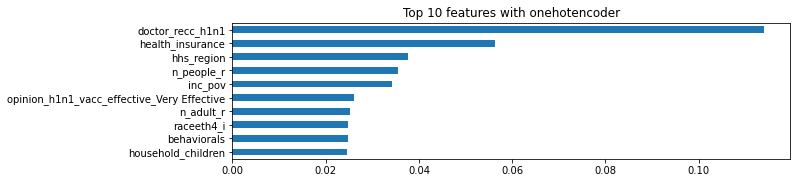

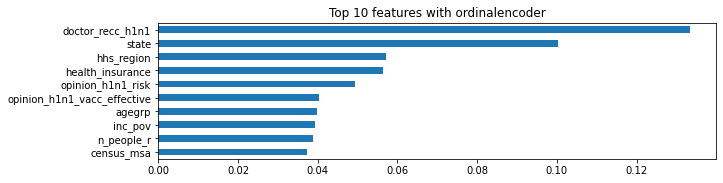

In [16]:
import matplotlib.pyplot as plt

# 특성 중요도(onehot)
rf = pipe.named_steps['randomforestclassifier']
colnames = pipe.named_steps['onehotencoder'].get_feature_names()
importances = pd.Series(rf.feature_importances_, colnames)

n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with onehotencoder')
importances.sort_values()[-n:].plot.barh();


# 특성 중요도(ordinal)
rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();


### 이제 이 두 가지 인코딩 방법이 선형 모델에 어떤 영향을 주는지 알아 봅시다.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe_lr = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(), 
    LogisticRegression(n_jobs=-1)
)
pipe_lr.fit(X_train, y_train)

print('검증세트 정확도', pipe_lr.score(X_val, y_val))

검증세트 정확도 0.8204246234135927


In [18]:
pipe_lr = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),  
    LogisticRegression(n_jobs=-1)
)
pipe_lr.fit(X_train, y_train)

print('검증세트 정확도', pipe_lr.score(X_val, y_val))

검증세트 정확도 0.797532914245048


순서형인코딩은 주의해야 할 것이 있습니다. 범주들을 순서가 있는 숫자형으로 바꾸면 원래 그 범주에 없던 순서정보가 생깁니다.

예를들어 food 특성에 ('밥', '빵') 이라는 두 범주가 있을 때 순서형 인코딩을 하면 ('1','2') 이렇게 인코딩이 됩니다. 원하지 않게 밥은 1, 빵은 2라는 순위를 매길수 있는 정보가 생겼습니다.

사실 순서형 인코딩은 범주들 간에 분명한 순위가 있을때 그 연관성에 맞게 숫자를 정해주는 것이 좋습니다. 예를들어 영화 평점과 같은 특성은 분명히 순서형 인코딩이 적절합니다.

지금까지는 OrdinalEncoder를 사용해 무작위로 수치를 인코딩 하였지만,

정확한 범주의 순위를 알고 있다면 `mapping` 파라미터를 사용해 지정해줄 수 있습니다. [OrdinalEncoder](https://contrib.scikit-learn.org/category_encoders/ordinal.html)


## 트리 앙상블 모델이 결정트리모델보다 상대적으로 과적합을 피할 수 있는 이유가 무엇일까요?

#### 랜덤포레스트의 랜덤성은 다음 두 가지에서 나옵니다.

결정트리는 데이터 일부에 과적합하는 경향이 있습니다. 그래서 다르게 샘플링된 데이터로 과적합된 트리를 많이 만들고 그 결과를 평균내 사용하는 모델이 랜덤 포레스트 입니다. 이렇게 하면 과적합이 줄고 성능이 유지 된다는 것이 알려져 있습니다.
랜텀포레스트에서 트리를 랜덤하게 만드는 방법은 두 가지 입니다.

1. 랜덤포레스트에서 학습되는 트리들은 배깅을 통해 만들어집니다.(`bootstrap = true`) 이때 각 기본트리에 사용되는 데이터가 랜덤으로 선택됩니다.
2. 각각 트리는 무작위로 선택된 특성들을 가지고 분기를 수행합니다.(`max_features = auto`.) 

#### 랜덤포레스트가 비선형 관계의 데이터를 적합하는 모습을 살펴 봅시다.
#### [Thurber dataset](https://www.itl.nist.gov/div898/strd/nls/data/thurber.shtml)
- Nonlinear Least Squares Regression

In [19]:
columns = ['mobility', 'density']
data = [[80.574, -3.067]
,[84.248, -2.981]
,[87.264, -2.921]
,[87.195, -2.912]
,[89.076, -2.84]
,[89.608, -2.797]
,[89.868, -2.702]
,[90.101, -2.699]
,[92.405, -2.633]
,[95.854, -2.481]
,[100.696, -2.363]
,[101.06, -2.322]
,[401.672, -1.501]
,[390.724, -1.46]
,[567.534, -1.274]
,[635.316, -1.212]
,[733.054, -1.1]
,[759.087, -1.046]
,[894.206, -0.915]
,[990.785, -0.714]
,[1090.109, -0.566]
,[1080.914, -0.545]
,[1122.643, -0.4]
,[1178.351, -0.309]
,[1260.531, -0.109]
,[1273.514, -0.103]
,[1288.339, 0.01]
,[1327.543, 0.119]
,[1353.863, 0.377]
,[1414.509, 0.79]
,[1425.208, 0.963]
,[1421.384, 1.006]
,[1442.962, 1.115]
,[1464.35, 1.572]
,[1468.705, 1.841]
,[1447.894, 2.047]
,[1457.628, 2.2]]

thurber = pd.DataFrame(columns=columns, data=data)
X_thurber = thurber[['mobility']]
y_thurber = thurber['density']

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth), 
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X_thurber, y_thurber)
        ax = thurber.plot('mobility', 'density', kind='scatter', title=name)
        ax.step(X_thurber, model.predict(X_thurber), where='mid')
        plt.show()
        
interact(trees, max_depth=(1,10,1), n_estimators=(10,50,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=10, min=1), IntSlider(value=10, descript…

### 랜덤포래스트 알고리즘을 확인해 봅시다.

랜덤포레스트의 의사코드(Pseudo code)는 다음과 같습니다.

<img src="https://i.imgur.com/OSJWosw.png" width="700" />

## 참고자료
- (예측모델 성능 비교 논문) [Data-driven advice for applying machine learning to bioinformatics problems](https://arxiv.org/abs/1708.05070)
- [MACHINE LEARNING LECTURE 8: ENSEMBLE METHODS
](https://vdocuments.mx/machine-learning-lecture-8-ensemble-methods.html)
- [Random Ferests](http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/ensembles/RandomForests.pdf) Algorithm
- [Testing Variable Importance in Random Forests](https://eeecon.uibk.ac.at/~zeileis/papers/Lifestat-2008.pdf)
- [One-Hot Encoding is making your Tree-Based Ensembles worse, here’s why?](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

# Exercise

# 랜덤포레스트(Random Forests)

### 1) 캐글 대회를 이어서 진행합니다. EDA, 데이터 전처리 부분을 업데이트 하세요.

- Ordinal Encoding을 적용해 보세요.
- **(객관식) 다음 특성들 중에 순서를 고려한 Ordinal Encoding이 필요해 보이는 특성을 고르세요.**
    1. opinion_h1n1_vacc_effective
    2. state
    3. marital
    4. employment_occupation


In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')


train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

In [22]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    #selected_cols = df.select_dtypes(include=['number', 'object'])
    #labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    #selected_features = labels[labels <= 60].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    #df = df[selected_features]

    low = ['MISSISSIPPI', 'GEORGIA', 'MISSOURI', 'LOUISIANA', 'IDAHO', 'FLORIDA', 'ALABAMA']
    middle = ['OKLAHOMA', 'TEXAS', 'ALABAMA', 'MONTANA', 'NEW YORK','MICHIGAN', 'SOUTH CAROLINA', 'NEW JERSEY', 'OHIO', 'PENNSYLVANIA', 'TENNESSEE',
            'NEVADA', 'DELAWARE', 'CONNECTICUT', 'ILLINOIS', 'DISTRICTOF COLUMBIA', 'NEW MEXICO', 'NORTH CAROLINA', 'WEST VIRGINIA', 'OREGON', 'ALASKA', 'WISCONSIN',
            'CALIFORNIA', 'COLORADO','ARIZONA']
    high = ['INDIANA', 'MARYLAND', 'WYOMING', 'UTAH', 'ARKANSAS', 'KANSAS', 'WASHINGTON', 'NORTH DAKOTA', 'NEBRASKA', 'MINNESOTA', 'IOWA', 'VIRGINIA',
            'VERMONT', 'NEW HAMPSHIRE', 'HAWAII']
    extreme = ['MAINE', 'SOUTH DAKOTA', 'MASSACHUSETTS', 'RHODE ISLAND']

    df['danger_state_level'] = 0

    num = len(df)
    for i in range(num):
      if df['state'].iloc[i] in low:
        df['danger_state_level'].iloc[i] = 'low'

      elif df['state'].iloc[i] in middle:
        df['danger_state_level'].iloc[i] = 'middle'
      
      elif df['state'].iloc[i] in high:
        df['danger_state_level'].iloc[i] = 'high'

      else:
        df['danger_state_level'].iloc[i] = 'extreme'
    
    df.drop(['state'], axis = 1, inplace=True)

    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

<ipython-input-22-ed8e050a3013>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['danger_state_level'].iloc[i] = 'middle'
<ipython-input-22-ed8e050a3013>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['danger_state_level'].iloc[i] = 'middle'
<ipython-input-22-ed8e050a3013>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['danger_state_level'].iloc[i] = 'high'


In [23]:
features = train.drop(columns=[target]).columns

# Diving training, validation, and testing data into X and y
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [24]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import KNNImputer

### 2) 랜덤포레스트 모델을 적용한 후의 결과를 캐글에 제출하세요.
- 랜덤포레스트를 적용하고 성능이 오히려 떨어졌을 수도 있습니다! 만약 그렇다면 이유를 본인 논리로 분석해 보세요.
- **캐글 Leaderboard의 본인 Score를 제출하세요.**

In [25]:
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.8226782113628277


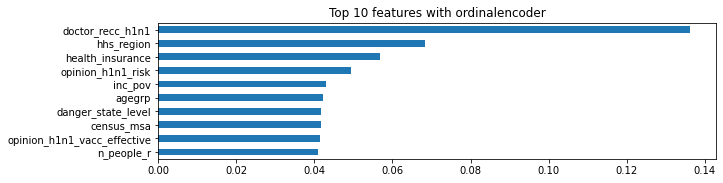

In [26]:
rf_ord = pipe_ord.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

n = 10

plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();

In [27]:
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    KNNImputer(), 
    RandomForestClassifier(random_state=10, n_estimators=200, min_samples_leaf=8, min_samples_split=7, n_jobs=-1,max_depth=14, oob_score=True)
)

# 'max_depth': 14, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200
# 'max_depth': 14, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 200
pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.8174593761119677


In [28]:
predict = pipe_ord.predict(X_val)
f1=f1_score(y_val, predict)

print("F1 score: {}" .format(f1))

F1 score: 0.5312214438014012


In [29]:
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    KNNImputer(), 
    RandomForestClassifier(random_state=10, n_estimators=200, min_samples_leaf=8, min_samples_split=8, n_jobs=-1,max_depth=14, oob_score=True)
)

# 'max_depth': 14, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200
# 'max_depth': 14, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 200
pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

predict = pipe_ord.predict(X_val)
f1=f1_score(y_val, predict)

print("F1 score: {}" .format(f1))

검증 정확도 0.8174593761119677
F1 score: 0.5312214438014012


In [30]:
# 테스트세트에 일반화 정도가 높아져 점수가 낮게 나오거나,
# 새롭게 바뀐 분석 방법에는 새로운 전처리 프로세스가 추가로 필요했을 것이다

In [31]:
predict = pipe_ord.predict(X_test)
filename = pd.DataFrame(predict)

filename.to_csv('submission.csv')

from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 참고자료

- [Random Forests for Complete Beginners](https://victorzhou.com/blog/intro-to-random-forests/)